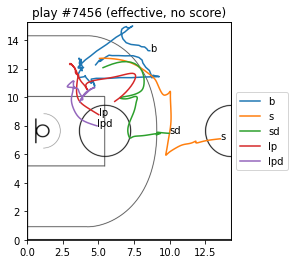

<Figure size 432x288 with 0 Axes>

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from numpy import array
import pandas as pd
from nba_data_preprocess import create_agent_df

downsampling = 1

data = pickle.load(open('dataset_as_a_file_600_games.pkl', 'rb'))

trajectories, label, indices, game_id, quarter = [array(d, dtype=object) for d in data]

combined_df = pd.concat([
    pd.DataFrame(label, index=indices),
    pd.DataFrame(game_id, index=indices).rename(columns={0: 'game_id'}),
    pd.DataFrame(quarter, index=indices).rename(columns={0: 'quarter'})
], axis=1, join='inner')

combined_df.iloc[combined_df[3]==2,3]=1.0
combined_df.iloc[combined_df[3]==3,3]=1.0

effective, t2, score = combined_df.iloc[:,0], combined_df.iloc[:,2], combined_df.iloc[:,3]
t_interval = combined_df.iloc[:,2][t2>0]

agent_labels = ['ball', 'shooter', 'shooterdefender', 'lastpasser', 'lastpasserdefender']
agent_dfs = {}
for label in agent_labels:
    agent_dfs[label] = create_agent_df(label, t_interval, trajectories, downsampling)

def plot_trajectory_on_court(phase_num, save_fig=False):
    if phase_num not in indices:
        print('Cannot plot that play')
    
    else:
        court_path ='nba_court_T.png'
        feet_m = 0.3048 
        img = mpimg.imread(court_path)
        plt.imshow(img, extent=[0,94*feet_m,0,50*feet_m], zorder=0) 
        plt.xlim(0,47*feet_m)  
        plt.ylim(0,50*feet_m)   
        
        items = [("b", agent_dfs["ball"].loc[phase_num]),
         ("s", agent_dfs["shooter"].loc[phase_num]),
         ("sd", agent_dfs["shooterdefender"].loc[phase_num]),
         ("lp", agent_dfs["lastpasser"].loc[phase_num]),
         ("lpd", agent_dfs["lastpasserdefender"].loc[phase_num])]

        for label, item in items:
            plt.plot(item['x'].interpolate(),
                     item['y'].interpolate(),
                     label=label, zorder=1)
            plt.annotate(label, (item['x'].iloc[0], item['y'].iloc[0]), zorder=2)
        
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        effective_score = int(effective[(phase_num,)])
        pts = int(score[(phase_num,)])
        
        if effective_score == 1 and pts > 0:
            title = f"play #{phase_num} (effective, scored {pts} pts)"
        elif effective_score == 0 and pts > 0:
            title = f"play #{phase_num} (ineffective, scored {pts} pts)"
        elif effective_score == 0 and pts == 0:
            title = f"play #{phase_num} (ineffective, no score)"
        elif effective_score == 1 and pts == 0:
            title = f"play #{phase_num} (effective, no score)"
        
        plt.title(title)

        if save_fig:
            plt.savefig(f"{phase_num}.png")
            plt.show()
        else:
            plt.show()
        plt.clf()
        
plot_trajectory_on_court(7456, False)